# Compare ROH between groups
Load empirical ROH Dataframe, and compare ROH sharing between groups with statistical tests (producing p-Values)
Assumes data is ROH analyzed, and pre-processed (into one dataframe, with region and clst Columns set.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
from scipy.stats import mannwhitneyu

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Mann Whitney U Test

In [ ]:
def test_mwu(df, region1="Iberia", region2="Iberia", clst1="Early Neolithic", clst2="Neolithic", 
             col="sum_roh_4-8", prt=True, alternative='two-sided', col_group="region"):
    """MWann Whitney U-Test. Print and return result and nr Individuals in each group
    df: Dataframe to test on
    prt: Whether to print the results"""
    df1 = df[(df["clst"]==clst1) & (df[col_group]==region1)]
    df2 = df[(df["clst"]==clst2) & (df[col_group]==region2)]
    
    test = mannwhitneyu(df1[col], df2[col], alternative=alternative)
    if prt:
        print(test)
        print(f"Loaded {len(df1)} Samples from clst {clst1} {region1}")
        print(f"Loaded {len(df2)} Samples from clst {clst2} {region2}")
        
    return test, len(df1), len(df2)

In [23]:
def test_mwu_groups(df1, df2, col="sum_roh_4-8",
                    prt=True, alternative='two-sided'):
    """Compare two Dataframes with values in col with mannwhitneyu Test"""
    test = mannwhitneyu(df1[col], df2[col], alternative=alternative)
    
    if prt:
        print(test)
        print(f"Loaded {len(df1)} Samples Set1")
        print(f"Loaded {len(df2)} Samples Set2") 
    return test, len(df1), len(df2)

### Tests of Mann Whitney U Test

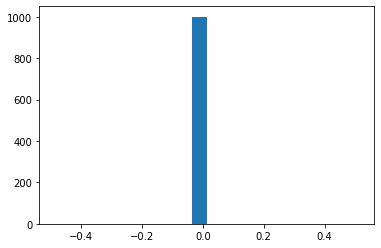

CPU times: user 465 ms, sys: 4.67 ms, total: 470 ms
Wall time: 526 ms


In [2]:
%%time
reps = 1000
mean1, mean2 = 1.0, 50.0
s1, s2 = 2, 20
std1, std2 = 1.0, 10.0

p = np.zeros(reps)

for i in range(reps):
    x = np.random.normal(loc=mean1, scale=std1, size=s1)
    y = np.random.normal(loc=mean2, scale=std2, size=s2)
    p[i] = mannwhitneyu(x, y)[1]
    
#### 
# Plot figures of distribution p-Values
plt.figure()
ax = plt.gca()
ax.hist(p, bins=20)
plt.show()

### Apply to empirical Data

In [2]:
### Load Big Data Frame (only ancients)
df = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df = df[df["age"]>0]
df["sum_roh_4-8"] = df["sum_roh>4"] - df["sum_roh>8"]

In [44]:
for reg in ["Iberia", "Balkans", "Rome", "Central Europe", "Black Sea", "Baltic Sea"]:
    test_mwu(df, region1=reg, region2=reg, clst1="Mesolithic", clst2="Early Neolithic")
    test_mwu(df, region1=reg, region2=reg, clst1="Early Neolithic", clst2="Neolithic")
    test_mwu(df, region1=reg, region2=reg, clst1="Mesolithic", clst2="Neolithic")
    print("\n")

MannwhitneyuResult(statistic=19.0, pvalue=0.8303242576557953)
Loaded 7 Samples from clst Mesolithic Iberia
Loaded 6 Samples from clst Early Neolithic Iberia
MannwhitneyuResult(statistic=128.0, pvalue=0.0038670303618025593)
Loaded 6 Samples from clst Early Neolithic Iberia
Loaded 24 Samples from clst Neolithic Iberia
MannwhitneyuResult(statistic=158.0, pvalue=0.000492384005230395)
Loaded 7 Samples from clst Mesolithic Iberia
Loaded 24 Samples from clst Neolithic Iberia


MannwhitneyuResult(statistic=302.0, pvalue=0.06454672358949157)
Loaded 37 Samples from clst Mesolithic Balkans
Loaded 12 Samples from clst Early Neolithic Balkans
MannwhitneyuResult(statistic=238.0, pvalue=0.22913306771562947)
Loaded 12 Samples from clst Early Neolithic Balkans
Loaded 32 Samples from clst Neolithic Balkans
MannwhitneyuResult(statistic=970.0, pvalue=5.524253515214728e-06)
Loaded 37 Samples from clst Mesolithic Balkans
Loaded 32 Samples from clst Neolithic Balkans


MannwhitneyuResult(statistic=27.0, pval

/home/hringbauer/.local/lib/python3.7/site-packages/scipy/stats/stats.py:5700: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


# Produce Table for Paper"
Produce Dataframes - these are then concatenated and saved into ./tablesout

In [4]:
regions = ["Iberia", "Balkans", "Rome", "Central Europe", "Black Sea", "Baltic Sea"]
periods = ["Mesolithic", "Early Neolithic", "Neolithic"]
prt = False

p1_vec, p2_vec = [], []
n1_vec, n2_vec = [], []
st_vec, p_vec = [], []

for reg in regions:
    for ps in it.combinations(periods, 2):
        t, i1, i2 = test_mwu(df, region1=reg, region2=reg, clst1=ps[0], clst2=ps[1], prt=prt)
        if (i1>0) and (i2>0):
            n1_vec.append(i1)
            n2_vec.append(i2)
            p1_vec.append(ps[0] + " " + reg)
            p2_vec.append(ps[1] + " " + reg)
            st_vec.append(t[0])
            p_vec.append(t[1])
            
#### Combine into one dataframe
df_res = pd.DataFrame({"Population 1": p1_vec, "Population 2": p2_vec, 
              "n1": n1_vec, "n2": n2_vec, "Statistic": st_vec, "p-Value": p_vec})

/home/hringbauer/.local/lib/python3.7/site-packages/scipy/stats/stats.py:5700: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


### Compare all Mesolithic Populations

In [5]:
regions = ["Iberia", "Balkans", "Rome", "Central Europe", "Black Sea", "Baltic Sea"]
periods = ["Mesolithic", "Early Neolithic", "Neolithic"]
prt = False

p1_vec, p2_vec = [], []
n1_vec, n2_vec = [], []
st_vec, p_vec = [], []

for prd in periods:
    for rgs in it.combinations(regions, 2):
        t, i1, i2 = test_mwu(df, region1=rgs[0], region2=rgs[1], clst1=prd, clst2=prd, prt=prt)
        if (i1>0) and (i2>0):
            n1_vec.append(i1)
            n2_vec.append(i2)
            p1_vec.append(prd + " " + rgs[0])
            p2_vec.append(prd + " " + rgs[1])
            st_vec.append(t[0])
            p_vec.append(t[1])
            
#### Combine into one dataframe
df_res1 = pd.DataFrame({"Population 1": p1_vec, "Population 2": p2_vec, 
              "n1": n1_vec, "n2": n2_vec, "Statistic": st_vec, "p-Value": p_vec})

/home/hringbauer/.local/lib/python3.7/site-packages/scipy/stats/stats.py:5700: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


### Combine and save final dataframe

In [6]:
df_res = pd.concat([df_res, df_res1])

In [7]:
savepath = "./TablesOut/p_vals_shifts.csv"
df_res.to_csv(savepath, index=False, header=True)
print(f"Saved to {savepath}")

Saved to ./TablesOut/p_vals_shifts.csv


In [8]:
df_res.head(10)

,Population 1,Population 2,n1,n2,Statistic,p-Value
0,Mesolithic Iberia,Early Neolithic Iberia,7,6,19.0,0.830324
1,Mesolithic Iberia,Neolithic Iberia,7,24,158.0,0.000492
2,Early Neolithic Iberia,Neolithic Iberia,6,24,128.0,0.003867
3,Mesolithic Balkans,Early Neolithic Balkans,37,12,302.0,0.064547
4,Mesolithic Balkans,Neolithic Balkans,37,32,970.0,0.000006
5,Early Neolithic Balkans,Neolithic Balkans,12,32,238.0,0.229133
6,Mesolithic Rome,Early Neolithic Rome,3,9,27.0,0.016044
7,Mesolithic Central Europe,Early Neolithic Central Europe,4,20,80.0,0.002119
8,Mesolithic Central Europe,Neolithic Central Europe,4,5,20.0,0.019964
9,Early Neolithic Central Europe,Neolithic Central Europe,20,5,30.0,0.183555


## Analysis for Sirak-Fernandez Paper

In [17]:
df_t = pd.read_csv("./Empirical/Eigenstrat/Sirak20/combined_roh05.csv", sep="\t")
df_t["sum_roh_4-8"] = df_t["sum_roh>4"] - df_t["sum_roh>8"]

In [18]:
df_t[df_t["pop"].str.contains("Cuba")]

,iid,pop,max_roh,sum_roh>4,n_roh>4,sum_roh>8,n_roh>8,sum_roh>12,n_roh>12,sum_roh>20,...,lat,lon,age,age_range,study,clst,mean_cov,n_cov_snp,include_alt,sum_roh_4-8
6,I10937,Cuba_PC_Guanataybes_3000BP,19.245398,197.068783,28,89.078182,8,31.484496,2,0.000000,...,23.038894,-81.495252,3046,"1187-1004 calBCE (2890±20 BP, PSUAMS-4864)",Sirak20,Cuba_PC_Guanataybes_3000BP,0.622512,747014,1,107.990601
13,I13487,Cuba_unknown,25.732401,167.725115,22,52.622305,3,43.373004,2,25.732401,...,23.038894,-81.495252,2050,1400 BCE - 1200 CE,Sirak20,Cuba_unknown,0.442270,530724,1,115.102810
36,I11169,Cuba_PC_Guanataybes_1300BP,18.753999,96.583808,12,53.293002,4,43.730003,3,0.000000,...,23.038894,-81.495252,1322,"605-651 calCE (1425±15 BP, PSUAMS-4868)",Sirak20,Cuba_PC_Guanataybes_1300BP,0.621566,745879,1,43.290806
60,I10757,Cuba_PC_Guanataybes,8.214600,73.450202,14,8.214600,1,0.000000,0,0.000000,...,23.038894,-81.495252,2050,1400 BCE - 1200 CE,Sirak20,Cuba_PC_Guanataybes,0.613718,736461,1,65.235602
76,I10756,Cuba_PC_Guanataybes,8.663797,57.772303,10,16.693997,2,0.000000,0,0.000000,...,23.038894,-81.495252,868,"1016-1148 calCE (980±15 BP, PSUAMS-5340)",Sirak20,Cuba_PC_Guanataybes,0.623518,748222,1,41.078306


### Test Cuba Early / Late

In [35]:
df1 = df_t[(df_t["pop"].str.contains("Cuba")) & (df_t["age"] > 2000)]
df2 = df_t[(df_t["pop"].str.contains("Cuba")) & (df_t["age"] <= 2000)]

test_mwu_groups(df1, df2, col="sum_roh_4-8",
                prt=True, alternative='two-sided')

MannwhitneyuResult(statistic=6.0, pvalue=0.14891467317876572)
Loaded 3 Samples Set1
Loaded 2 Samples Set2


(MannwhitneyuResult(statistic=6.0, pvalue=0.14891467317876572), 3, 2)

### Test Cuba Early vrs Tainio

In [34]:
df1 = df_t[(df_t["pop"].str.contains("Cuba")) & (df_t["age"] > 2000)]
df2 = df_t[(df_t["pop"].str.contains("Dominican"))]

test_mwu_groups(df1, df2, col="sum_roh_4-8",
                prt=True, alternative='two-sided')

MannwhitneyuResult(statistic=340.0, pvalue=0.0036654464878695986)
Loaded 3 Samples Set1
Loaded 114 Samples Set2


(MannwhitneyuResult(statistic=340.0, pvalue=0.0036654464878695986), 3, 114)

### Test Venezuela

In [39]:
df1 = df_t[(df_t["pop"].str.contains("Venezuela")) & (df_t["age"] > 1000)]
df2 = df_t[(df_t["pop"].str.contains("Venezuela")) & (df_t["age"] <= 1000)]

test_mwu_groups(df1, df2, col="sum_roh_4-8",
                prt=True, alternative='two-sided')

MannwhitneyuResult(statistic=36.0, pvalue=0.027468640385681333)
Loaded 18 Samples Set1
Loaded 2 Samples Set2


(MannwhitneyuResult(statistic=36.0, pvalue=0.027468640385681333), 18, 2)

# Area 51